In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import scipy.constants
import math

import warnings
warnings.filterwarnings("ignore")

font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)

# Constants
GAS_CONSTANT = 8.314462618 * 10**(-3)

def get_betadmua_dlnxa(saa,sab,sbb,xa):
    xb = 1.0 - xa
    return 1.0 / (xb * saa + xa * sbb - 2 * (xa * xb) ** 0.5 * sab)

def mu_mol_frac(saa,sab,sbb,xa,x0,kbt):
    # xa are 1-D array with N-dim
    # saa,sab,sbb are (2,N) array, [S, S_error]
    
    logxa = np.log(xa)
    integrand = get_betadmua_dlnxa(saa[:,0],sab[:,0],sbb[:,0],xa)
    integrand_error = np.sqrt((xa**2*saa[:,1]**2 + 4*xa*(1-xa)*sab[:,1]**2 + 
                               (1-xa)**2*sbb[:,1]**2)/(xa*saa[:,0] + (1-xa)*sbb[:,0] - 2*sab[:,0]*(xa*(1-xa))**0.5)**4)   
    
    mask = ~np.isnan(integrand)
    int_func = interp1d(logxa[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logxa[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')
    
    # integrate
    xa_mu = []
    n_sample = 0
    for i,a in enumerate(logxa):
        n_sample += 1
        mu_now = kbT*quad(int_func, np.log(x0), a)[0]
        if n_sample >= 2:
            mu_error_now = kbT*quad(int_error_func, np.log(x0), a)[0]/(n_sample-1)**0.5
        else:
            mu_error_now = kbT*quad(int_error_func, np.log(x0), a)[0]
        xa_mu.append([xa[i], mu_now, abs(mu_error_now)])
        
    return np.asarray(xa_mu)

def read_data(file_path):
    data = pd.read_table(file_path, sep=' ', skiprows=2, 
                         names=["x", "AA", "AA_err", "AB", "AB_err", "BB", "BB_err"], engine='python')
    x_eth = np.array(data['x'])
    x_water = 1 - x_eth

    S_AA = np.array(data[['AA', 'AA_err']]) 
    S_AB = np.array(data[['AB', 'AB_err']])
    S_BB = np.array(data[['BB', 'BB_err']])
    
    return x_eth, x_water, S_AA, S_AB, S_BB

def process_data_gamma(file_path, T):
    x_eth, x_water, S_AA, S_AB, S_BB = read_data(file_path)

    kbT = GAS_CONSTANT*T 
    excess_mu_eth_part = mu_mol_frac(S_AA, S_AB, S_BB, x_eth, 1, kbT)
    excess_mu_water_part = mu_mol_frac(S_BB, S_AB, S_AA, x_water, 1, kbT)

    gamma_eth = np.exp(excess_mu_eth_part[:, 1] / kbT) / x_eth
    gamma_water = np.exp(excess_mu_water_part[:, 1] / kbT) / x_water

    return x_eth, gamma_eth, gamma_water

In [6]:
from phasepy import component, mixture, prsveos
import CoolProp.CoolProp as CP

water = component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87292043, -0.06844994],
                Ant =  [  11.72091059, 3852.20302815,  -44.10441047],
                cii = [ 1.16776082e-25, -4.76738739e-23,  1.79640647e-20],
                GC = {'H2O':1},
                ri=0.92, qi=1.4)

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                Ant = [  12.26474221, 3851.89284329,  -36.99114863],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1},
                ri=2.1055, qi=1.972)

mix = mixture(ethanol, water)

#Vapor Liquid equilibria data obtanied from Rieder, Robert M. y A. Ralph Thompson (1949).
# Vapor-Liquid Equilibria Measured by a GillespieStill - Ethyl Alcohol - Water System. 
#Ind. Eng. Chem. 41.12, 2905-2908.

#Saturation Pressure in bar
Pexp = np.array([1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013])

#Saturation temeprature in Kelvin
Texp = np.array([372.45, 370.05, 369.15, 369.15, 368.75, 367.95, 366.95, 366.65,
       366.05, 363.65, 363.65, 362.55, 361.55, 361.75, 360.35, 358.55,
       357.65, 357.15, 356.55, 356.15, 355.45, 355.15, 354.55, 354.65,
       354.35, 354.05, 353.65, 353.35, 353.15, 352.65, 351.95, 351.65,
       351.55, 351.45])

#Liquid fraction mole array
Xexp = np.array([[0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302,
        0.0331, 0.0519, 0.053 , 0.0625, 0.0673, 0.0715, 0.0871, 0.126 ,
        0.143 , 0.172 , 0.206 , 0.21  , 0.255 , 0.284 , 0.321 , 0.324 ,
        0.345 , 0.405 , 0.43  , 0.449 , 0.506 , 0.545 , 0.663 , 0.735 ,
        0.804 , 0.917 ],
       [0.9972, 0.9882, 0.9863, 0.9856, 0.9824, 0.9778, 0.9754, 0.9698,
        0.9669, 0.9481, 0.947 , 0.9375, 0.9327, 0.9285, 0.9129, 0.874 ,
        0.857 , 0.828 , 0.794 , 0.79  , 0.745 , 0.716 , 0.679 , 0.676 ,
        0.655 , 0.595 , 0.57  , 0.551 , 0.494 , 0.455 , 0.337 , 0.265 ,
        0.196 , 0.083 ]])

#Vapor fraction mole array
Yexp = np.array([[0.032, 0.113, 0.157, 0.135, 0.156, 0.186, 0.212, 0.231, 0.248,
        0.318, 0.314, 0.339, 0.37 , 0.362, 0.406, 0.468, 0.487, 0.505,
        0.53 , 0.527, 0.552, 0.567, 0.586, 0.586, 0.591, 0.614, 0.626,
        0.633, 0.661, 0.673, 0.733, 0.776, 0.815, 0.906],
       [0.968, 0.887, 0.843, 0.865, 0.844, 0.814, 0.788, 0.769, 0.752,
        0.682, 0.686, 0.661, 0.63 , 0.638, 0.594, 0.532, 0.513, 0.495,
        0.47 , 0.473, 0.448, 0.433, 0.414, 0.414, 0.409, 0.386, 0.374,
        0.367, 0.339, 0.327, 0.267, 0.224, 0.185, 0.094]])

datavle = (Xexp, Yexp, Texp, Pexp)


from phasepy.fit import fit_uniquac, fit_nrtl

mixuniquac = mix.copy()
mixnrtl = mix.copy()

#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True)

nrtl0 = np.array([-80.,  650.,  0.2])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = False)

nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'Abbott')

# initial guesses for the interaction energies (in K)
A0 = np.array([100., 200])
fit_uniquac(A0, mixuniquac, datavle)

from phasepy import virialgamma

virialuniquac = virialgamma(mixuniquac, actmodel='uniquac')
virialnrtl = virialgamma(mixnrtl, actmodel = 'nrtl')

#Xexp_mod = np.array([[0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302,
#        0.0331, 0.0519, 0.053 , 0.0625, 0.0673, 0.0715, 0.0871, 0.126 ,
#        0.143 , 0.172 , 0.206 , 0.21  , 0.255 , 0.284 , 0.321 , 0.324 ,
#        0.345 , 0.405 , 0.43  , 0.449 , 0.506 , 0.545 , 0.663 , 0.735 ,
#        0.804 , 0.917, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99 ],                     
#       [0.9972, 0.9882, 0.9863, 0.9856, 0.9824, 0.9778, 0.9754, 0.9698,
#        0.9669, 0.9481, 0.947 , 0.9375, 0.9327, 0.9285, 0.9129, 0.874 ,
#        0.857 , 0.828 , 0.794 , 0.79  , 0.745 , 0.716 , 0.679 , 0.676 ,
#        0.655 , 0.595 , 0.57  , 0.551 , 0.494 , 0.455 , 0.337 , 0.265 ,
#        0.196 , 0.083, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01 ]])

Xexp_mod = np.array([np.linspace(0,1,100), 1- np.linspace(0,1,100)])

In [7]:
T = 352 #K
kbK_2_kjmol = 8.314462618*10**(-3)
# Boltzmann constant times temperature in kJ/mol
kbT = kbK_2_kjmol*T 

N_A = scipy.constants.Avogadro
Mr_water   = 18.02
Mr_ethanol = 46.07

c_pure_water = CP.PropsSI('Dmolar','T',T, 'P|liquid',1e5, 'Water')/1e3
c_pure_eth = CP.PropsSI('Dmolar','T',T, 'P|liquid',1e5, 'Ethanol')/1e3

In [ ]:
def calculate_concentrations(x_eth, den_py, Mr_ethanol, Mr_water):
    mean_Mr = np.asarray([X_ratio * Mr_ethanol + (1 - X_ratio) * Mr_water for X_ratio in x_eth])

    c_mol_liter_total = den_py * 1e3 / mean_Mr
    c_mol_liter_eth   = c_mol_liter_total *  x_eth
    c_mol_liter_water = c_mol_liter_total *  (1 - x_eth)
    
    return  c_mol_liter_eth, c_mol_liter_water


file_path_gmx = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Liquid_352K_1bar_gmx_trappeUA_8.txt"
x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx)

den_py = []
for eth_mol_frac in x_eth_gmx:
    water_mol_frac = 1 - eth_mol_frac
    den = CP.PropsSI('Dmass','T',T, 'P|liquid',1e5, f'Ethanol[{eth_mol_frac}]&Water[{water_mol_frac}]')/1e3
    den_py.append(den)
den_py = np.array(den_py)  
c_eth, c_water   = calculate_concentrations(x_eth_gmx, den_py, Mr_ethanol, Mr_water)

mu_water_cmol = mu_molL_excess(c_water, S_BB, S_AB, x_water_gmx/x_eth_gmx, c_pure_water, kbT)
mu_eth_cmol   = mu_molL_excess(c_eth,   S_AA, S_AB, x_eth_gmx/x_water_gmx, c_pure_eth, kbT)

In [ ]:
file_path_gmx = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Liquid_352K_1bar_gmx_trappeUA_8.txt"
x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx)
mu_eth_gmx = mu_mol_frac(S_AA, S_AB, S_BB, x_eth_gmx, 1, kbT)
mu_water_gmx = mu_mol_frac(S_BB, S_AB, S_AA, x_water_gmx, 1, kbT)

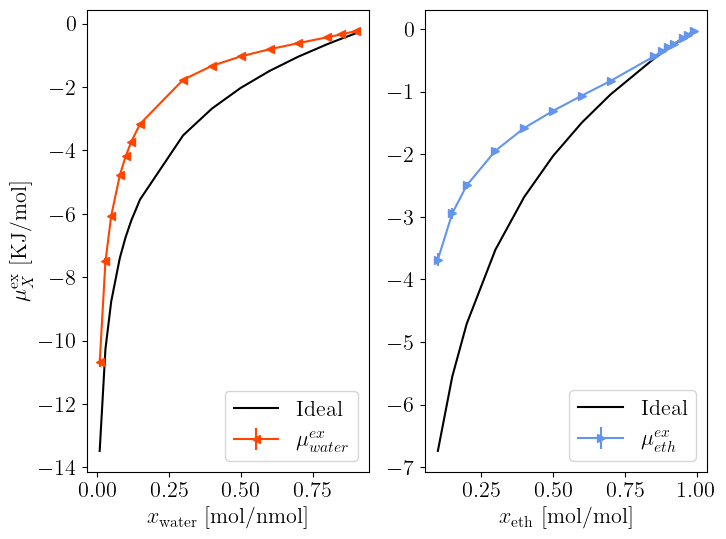

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot data on the first subplot
axs[0].errorbar(x_water_gmx, mu_water_gmx[:,1], \
        abs(mu_water_gmx[:,2]), \
        c = "orangered", marker = "<", label=r"$ \mu^{ex}_{water} $ ")
axs[0].plot(x_water_gmx, kbT*np.log(x_water_gmx), \
        c="black", label='Ideal')
axs[0].set_xlabel("$x_{\mathrm{water}}$ [mol/nmol]")
axs[0].set_ylabel(r"$ \mu^{\mathrm{ex}}_{X} $ [KJ/mol]")
axs[0].legend()

# Plot data on the second subplot
axs[1].errorbar(x_eth_gmx, mu_eth_gmx[:,1], \
        abs(mu_eth_gmx[:,2]), \
        c = "cornflowerblue", marker = ">", label=r"$ \mu^{ex}_{eth} $ ")
axs[1].plot(x_eth_gmx, kbT*np.log(x_eth_gmx),  \
        c="black", label='Ideal')
axs[1].set_xlabel("$x_{\mathrm{eth}}$ [mol/mol]")
axs[1].legend(loc=4)

Text(0.83, -1.98, '352 K')

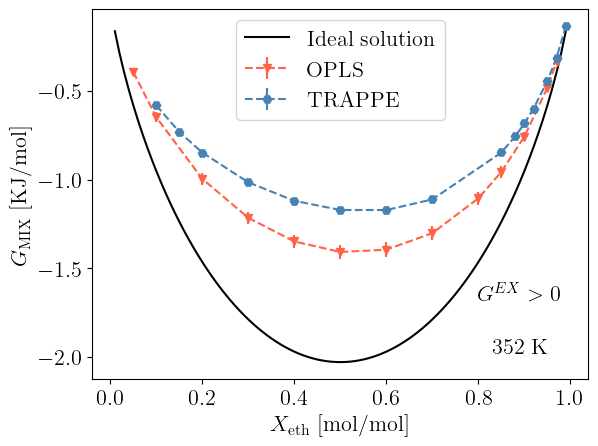

In [9]:
file_path_opls = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Liquid_352K_1bar_gmx.txt"
x_eth_opls, x_water_opls, S_AA_opls, S_AB_opls, S_BB_opls = read_data(file_path_opls)
mu_eth_opls = mu_mol_frac(S_AA_opls, S_AB_opls, S_BB_opls, x_eth_opls, 1, kbT)
mu_water_opls = mu_mol_frac(S_BB_opls, S_AB_opls, S_AA_opls, x_water_opls, 1, kbT)
mix_mu_sol_opls = x_eth_opls*mu_eth_opls[:,1] + x_water_opls*mu_water_opls[:,1] 
mix_mu_sol_opls_err = x_eth_opls*mu_eth_opls[:,2] + x_water_opls*mu_water_opls[:,2] 
plt.errorbar(x_eth_opls, mix_mu_sol_opls, mix_mu_sol_opls_err, \
        marker = "v", ls = "--", \
        c="tomato", label="OPLS")

file_path_gmx = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Liquid_352K_1bar_gmx_trappeUA_8.txt"
x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx)
mu_eth_gmx = mu_mol_frac(S_AA, S_AB, S_BB, x_eth_gmx, 1, kbT)
mu_water_gmx = mu_mol_frac(S_BB, S_AB, S_AA, x_water_gmx, 1, kbT)
mix_mu_sol_gmx = x_eth_gmx*mu_eth_gmx[:,1] + x_water_gmx*mu_water_gmx[:,1] 
mix_mu_sol_gmx_err = x_eth_gmx*mu_eth_gmx[:,2] + x_water_gmx*mu_water_gmx[:,2] 
plt.errorbar(x_eth_gmx, mix_mu_sol_gmx, mix_mu_sol_gmx_err, \
    marker = "H", ls = "--", \
    c="steelblue", label="TRAPPE")


#- kbT*(x_eth*np.log(x_eth)+(x_water)*np.log(x_water))

x_fit   = np.linspace(0.01, 1, 100)
ideal_mu = kbT*(x_fit*np.log(x_fit)+(1-x_fit)*np.log(1-x_fit))
plt.plot(x_fit, ideal_mu, c="black", ls="-", label="Ideal solution")

plt.legend()

plt.ylabel(r"$ G_{\mathrm{MIX}} $ [KJ/mol]")
plt.xlabel("$X_\mathrm{{eth}}$ [mol/mol]")

plt.text(0.8, -1.68, str("$G^{EX} > 0 $"))
plt.text(0.83, -1.98, str("352 K"))

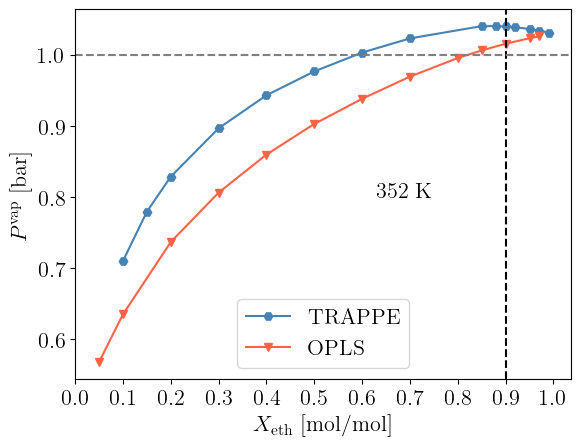

In [ ]:
P_sat_eth = CP.PropsSI('P', 'T', T, 'Q', 1, 'ethanol')/1e5
P_sat_water = CP.PropsSI('P', 'T', T, 'Q', 1, 'water')/1e5

P_vap_trappe = P_sat_eth*np.exp(mu_eth_gmx[:, 1] / kbT) + P_sat_water *np.exp(mu_water_gmx[:, 1] / kbT)
plt.plot(x_eth_gmx, P_vap_trappe, \
        marker = "H", ls = "-", \
        c="steelblue", label="TRAPPE")


P_vap_opls = P_sat_eth*np.exp(mu_eth_opls[:, 1] / kbT) + P_sat_water *np.exp(mu_water_opls[:, 1] / kbT)
plt.plot(x_eth_opls, P_vap_opls,\
        marker = "v", ls = "-", \
        c="tomato", label="OPLS")


plt.axvline(x=0.9, ls="--", color='black')
plt.axhline(y=1.0, ls="--", color='grey')

plt.ylabel(r"$ P^{\mathrm{vap}} $ [bar]")
plt.xlabel(r"$X_{\mathrm{eth}}$ [mol/mol]")

plt.text(0.63, 0.8, str("352 K"))
plt.xticks(np.arange(0, 1.1, step=0.1))

plt.legend()

x_eth_gmx_T352K = x_eth_gmx
P_vap_total_T352K = P_vap_trappe

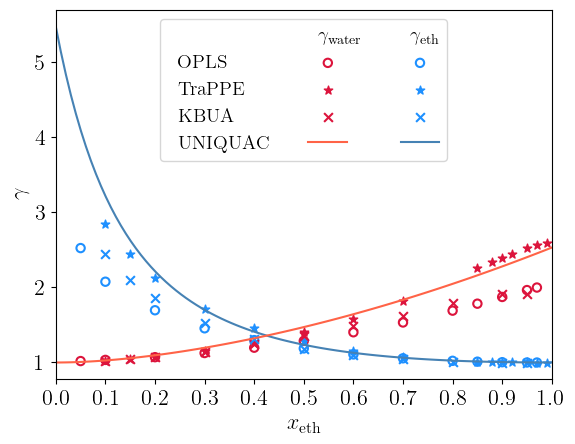

In [61]:
import numpy
import pylab
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig = plt.figure()
ax = fig.add_subplot(111)
plt.rcParams['text.usetex'] = True


Xexp_mod = np.array([np.linspace(0,1,100), 1- np.linspace(0,1,100)])
ac_uniquac = [] 
ac_nrtl = []
for i in range(len(Xexp_mod[0])):
    lnac_uniquac = virialgamma.lngama(virialuniquac, Xexp_mod[:,i], 352)  
    lnac_nrtl    = virialgamma.lngama(virialnrtl, Xexp_mod[:,i], 352) 
    ac_uniquac.append(math.e**lnac_uniquac)
    ac_nrtl.append(math.e**lnac_nrtl)

ac_uniquac = np.array(ac_uniquac)

uniquac_eth , = ax.plot(Xexp_mod[0], ac_uniquac[:,0], color='steelblue', ls='-',label="Eth")
uniquac_water , = ax.plot(Xexp_mod[0], ac_uniquac[:,1], color='tomato', ls='-', label="Water")

#file_path_gmx = "/Users/wangxiaoyu/Desktop/Liquid_352K_1bar_gmx_trappeUA.txt"
file_path_gmx_opls = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Liquid_352K_1bar_gmx.txt"
x_eth_gmx_opls, gamma_eth_gmx_opls, gamma_water_gmx_opls = process_data_gamma(file_path_gmx_opls, 352)
opls_water = ax.scatter(x_eth_gmx_opls, gamma_water_gmx_opls, c='None', linewidths=1.5,  \
            edgecolors='crimson' , label="OPLS: Water")
opls_eth = ax.scatter(x_eth_gmx_opls, gamma_eth_gmx_opls,   c='None',  linewidths=1.5, \
            edgecolors='dodgerblue', label="OPLS: Eth")

file_path_gmx_trappe = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs//Desktop/Liquid_352K_1bar_gmx_trappeUA_8.txt"
x_eth_gmx_trappe, gamma_eth_gmx_trappe, gamma_water_gmx_trappe = process_data_gamma(file_path_gmx_trappe, 352)
trappe_water = ax.scatter(x_eth_gmx_trappe, gamma_water_gmx_trappe, marker="*", \
            s=40, c='crimson', label="TRAPPE: Water")
trappe_eth = ax.scatter(x_eth_gmx_trappe, gamma_eth_gmx_trappe, marker="*", \
            s=40, c='dodgerblue', label="TRAPPE: Eth")


file_path_gmx_KB = "/Users/xiaoyuwang/Library/Mobile Documents/com~apple~CloudDocs//Desktop/Liquid_352K_1bar_gmx_kbff.txt"
x_eth_gmx_KB, gamma_eth_gmx_KB, gamma_water_gmx_KB = process_data_gamma(file_path_gmx_KB, 352)
KB_water = ax.scatter(x_eth_gmx_KB, gamma_water_gmx_KB, marker="x", \
            s=40, c='crimson', label="KBUA: Water")
KB_eth = ax.scatter(x_eth_gmx_KB, gamma_eth_gmx_KB, marker="x", \
            s=40, c='dodgerblue', label="KBUA: Eth")


#file_path_lmp = "/Users/wangxiaoyu/Desktop/Liquid_352K_1bar_lmp.txt"
#x_eth_lmp, gamma_eth_lmp, gamma_water_lmp = process_data_gamma(file_path_lmp, 352)
#plt.scatter(x_eth_lmp, gamma_water_lmp, marker="s", c='None', linewidths=1.5, \
#            edgecolors='tomato',  label="LMP: water")
#plt.scatter(x_eth_lmp, gamma_eth_lmp,  marker="s", c='None', linewidths=1.5,  \
#            edgecolors='cornflowerblue',  label="LMP: ethanol")

ax.set_ylabel("$\gamma$", weight='bold')
ax.set_xlabel("$x_\mathrm{{eth}}$ ")

plt.xticks(np.arange(0, 1.1, step=0.1))
plt.margins(x=0)

########################################################################################################################################################################
#Create organized list containing all handles for table. Extra represent empty space
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

legend_handle = [extra, extra, extra, extra, extra,extra, opls_water, trappe_water, KB_water, uniquac_water, extra, opls_eth , trappe_eth, KB_eth, uniquac_eth]


#Define the labels
label_col_1 = [r"", r"OPLS", r"TraPPE", r"KBUA", r"UNIQUAC"]
label_j_1 = [r"$\mathbf{\gamma_\mathrm{{water}}}$"]
label_j_2 = [r"$\mathbf{\gamma_\mathrm{{eth}}}$"]
label_empty = [""]

#organize labels for table construction
legend_labels = numpy.concatenate([label_col_1 ,label_j_1, label_empty * 4, label_j_2, label_empty * 4])

#Create legend
ax.legend(legend_handle, legend_labels, 
          loc = 9, ncol = 3, shadow = None, handletextpad = -1.5, fontsize = 14)


Text(0.6, 0.8, '352 K')

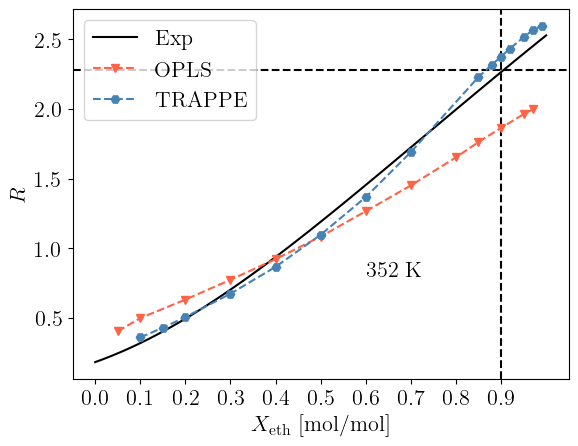

In [35]:
ac_uniquac = np.array(ac_uniquac)
plt.plot(Xexp_mod[0], ac_uniquac[:,1]/ac_uniquac[:,0], label="Exp", c='black')

P_sat_eth = CP.PropsSI('P', 'T', T, 'Q', 1, 'ethanol')/1e5
P_sat_water = CP.PropsSI('P', 'T', T, 'Q', 1, 'water')/1e5
R_gamma =P_sat_water/P_sat_eth

plt.axhline(y=1/R_gamma, ls="--", color='black')
plt.axvline(x=0.9, ls="--", color='black')

plt.plot(x_eth_gmx_opls, gamma_water_gmx_opls/gamma_eth_gmx_opls, \
            marker ="v", c='tomato', ls = "--", label="OPLS")
plt.plot(x_eth_gmx_trappe, gamma_water_gmx_trappe/gamma_eth_gmx_trappe, \
            marker ="H", c='steelblue', ls = "--", label="TRAPPE")


plt.legend(loc=2)
plt.xticks(np.arange(0, 1.0, step=0.1))
plt.ylabel(r"$ R $ ")
plt.xlabel("$X_\mathrm{{eth}}$ [mol/mol]")

plt.text(0.6, 0.8, str("352 K"))


# Vary Temperature now

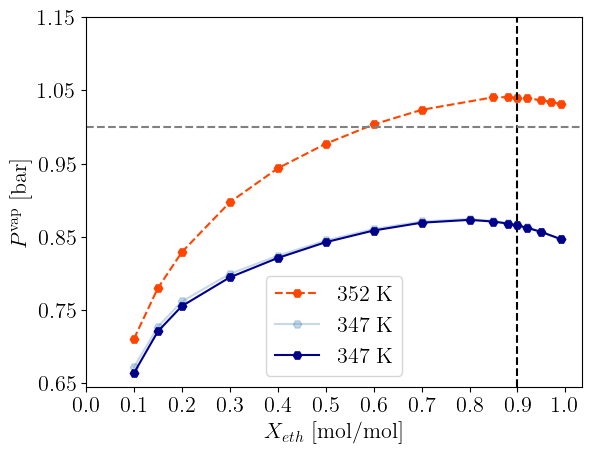

In [ ]:
plt.plot(x_eth_gmx_T352K, P_vap_total_T352K, \
        marker = "H", ls = "--", \
        c="orangered", label="352 K")

plt.axvline(x=0.9, ls="--", color='black')
plt.axhline(y=1.0, ls="--", color='grey')

plt.ylabel(r"$ P^{\mathrm{vap}} $ [bar]")
plt.xlabel("$X_{eth}$ [mol/mol]")

#plt.text(0.63, 0.8, str("352 K"))

x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx_trappe)
mu_eth_gmx = mu_mol_frac(S_AA, S_AB, S_BB, x_eth_gmx, 1, kbT)
mu_water_gmx = mu_mol_frac(S_BB, S_AB, S_AA, x_water_gmx, 1, kbT)

P_vap_trappe = P_sat_eth*np.exp(mu_eth_gmx[:, 1] / kbT) + P_sat_water *np.exp(mu_water_gmx[:, 1] / kbT)
plt.plot(x_eth_gmx, P_vap_trappe, \
        marker = "H", ls = "-", \
        c="steelblue", label="347 K", alpha = 0.3)

file_path_gmx_trappe_cp = "/Users/wangxiaoyu/Desktop/Liquid_347K_1bar_gmx_trappeUA_8_cp.txt"
x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx_trappe_cp)
mu_eth_gmx = mu_mol_frac(S_AA, S_AB, S_BB, x_eth_gmx, 1, kbT)
mu_water_gmx = mu_mol_frac(S_BB, S_AB, S_AA, x_water_gmx, 1, kbT)

P_vap_trappe = P_sat_eth*np.exp(mu_eth_gmx[:, 1] / kbT) + P_sat_water *np.exp(mu_water_gmx[:, 1] / kbT)
plt.plot(x_eth_gmx, P_vap_trappe, \
        marker = "H", ls = "-", \
        c="darkblue", label="347 K")

plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0.65, 1.2, step=0.1))
plt.legend()


# Double check 370K

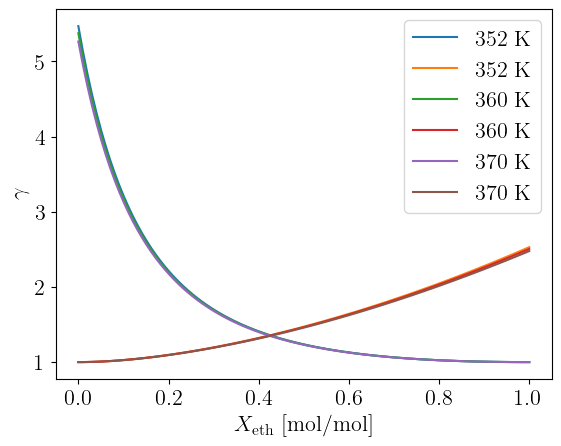

In [ ]:
ac_uniquac = [] 
ac_nrtl = []

T1 = 352
for i in range(len(Xexp_mod[0])):
    lnac_uniquac = virialgamma.lngama(virialuniquac, Xexp_mod[:,i], T1)  
    lnac_nrtl    = virialgamma.lngama(virialnrtl, Xexp_mod[:,i], T1) 
    ac_uniquac.append(math.e**lnac_uniquac)
    ac_nrtl.append(math.e**lnac_nrtl)

plt.plot(Xexp_mod[0], ac_uniquac, label=f"{T1} K")


T2 = 360
ac_uniquac = [] 
ac_nrtl = []
for i in range(len(Xexp_mod[0])):
    lnac_uniquac = virialgamma.lngama(virialuniquac, Xexp_mod[:,i], T2)  
    lnac_nrtl    = virialgamma.lngama(virialnrtl, Xexp_mod[:,i], T2) 
    ac_uniquac.append(math.e**lnac_uniquac)
    ac_nrtl.append(math.e**lnac_nrtl)

plt.plot(Xexp_mod[0], ac_uniquac, label=f"{T2} K ")

T3 = 370
ac_uniquac = [] 
ac_nrtl = []
for i in range(len(Xexp_mod[0])):
    lnac_uniquac = virialgamma.lngama(virialuniquac, Xexp_mod[:,i], T3)  
    lnac_nrtl    = virialgamma.lngama(virialnrtl, Xexp_mod[:,i], T3) 
    ac_uniquac.append(math.e**lnac_uniquac)
    ac_nrtl.append(math.e**lnac_nrtl)

plt.plot(Xexp_mod[0], ac_uniquac, label=f"{T3} K")


plt.legend()
plt.ylabel(r"$ \gamma $")
plt.xlabel("$X_\mathrm{{eth}}$ [mol/mol]")
plt.legend(ncol=1, fontsize = 16)


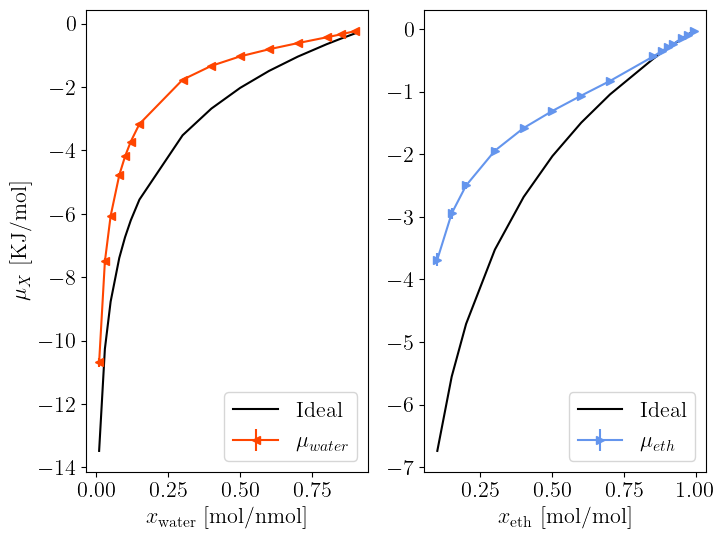

In [ ]:
file_path_gmx = "/Users/wangxiaoyu/Desktop/Liquid_352K_1bar_gmx_trappeUA_8.txt"
x_eth_gmx, x_water_gmx, S_AA, S_AB, S_BB = read_data(file_path_gmx)
mu_eth_gmx = mu_mol_frac(S_AA, S_AB, S_BB, x_eth_gmx, 1, kbT)
mu_water_gmx = mu_mol_frac(S_BB, S_AB, S_AA, x_water_gmx, 1, kbT)

T = 352 #K
kbK_2_kjmol = 8.314462618*10**(-3)
# Boltzmann constant times temperature in kJ/mol
kbT = kbK_2_kjmol*T 

den_py = []
for eth_mol_frac in x_eth_gmx:
    water_mol_frac = 1 - eth_mol_frac
    den = CP.PropsSI('Dmass','T',T, 'P|liquid',1e5, f'Ethanol[{eth_mol_frac}]&Water[{water_mol_frac}]')/1e3
    den_py.append(den)
den_py = np.array(den_py)  
c_eth, c_water   = calculate_concentrations(x_eth_gmx, den_py, Mr_ethanol, Mr_water)

mu_water_cmol = mu_molL_excess(c_water, S_BB, S_AB, x_water_gmx/x_eth_gmx, c_pure_water, kbT)
mu_eth_cmol   = mu_molL_excess(c_eth,   S_AA, S_AB, x_eth_gmx/x_water_gmx, c_pure_eth, kbT)

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot data on the first subplot
axs[0].errorbar(x_water_gmx, mu_water_gmx[:,1], \
        abs(mu_water_gmx[:,2]), \
        c = "orangered", marker = "<", label=r"$ \mu_{water} $ ")
axs[0].plot(x_water_gmx, kbT*np.log(x_water_gmx), \
        c="black", label='Ideal')
axs[0].set_xlabel("$x_{\mathrm{water}}$ [mol/nmol]")
axs[0].set_ylabel(r"$ \mu_{X} $ [KJ/mol]")
axs[0].legend()

# Plot data on the second subplot
axs[1].errorbar(x_eth_gmx, mu_eth_gmx[:,1], \
        abs(mu_eth_gmx[:,2]), \
        c = "cornflowerblue", marker = ">", label=r"$ \mu_{eth} $ ")
axs[1].plot(x_eth_gmx, kbT*np.log(x_eth_gmx),  \
        c="black", label='Ideal')
axs[1].set_xlabel("$x_{\mathrm{eth}}$ [mol/mol]")
axs[1].legend(loc=4)